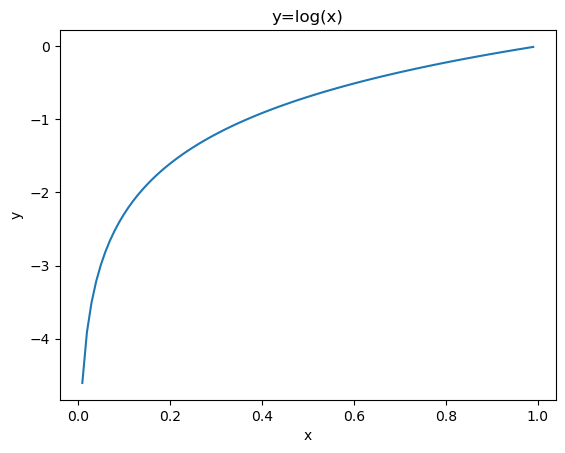

In [24]:
import matplotlib.pyplot as plt
import numpy as np
x = np.arange(0.01,1,0.01)
y = np.log(x)
plt.title('y=log(x)')
plt.xlabel('x')
plt.ylabel('y')
plt.plot(x,y)
plt.show()

In [25]:
from data_process import get_MNIST_dataloader
train_loader,test_loader = get_MNIST_dataloader()
import paddle 
from paddle.nn import Conv2D,MaxPool2D,Linear
from paddle.nn import Linear
import paddle.nn.functional as F
class MNIST(paddle.nn.Layer):
    def __init__(self):
        super(MNIST, self).__init__()
        self.conv1 = Conv2D(in_channels=1,out_channels=20,kernel_size=5,stride=1,padding=2)
        self.max_pool1 = MaxPool2D(kernel_size=2,stride=2)
        self.conv2 = Conv2D(in_channels=20,out_channels=20,kernel_size=5,stride=1,padding=2)
        self.max_pool2 = MaxPool2D(kernel_size=2,stride=2)
        self.fc = Linear(in_features=980,out_features=10)
    def forward(self,inputs):
        x = self.conv1(inputs)
        x = F.relu(x)
        x = self.max_pool1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.max_pool2(x)
        x = paddle.reshape(x,[x.shape[0],-1])
        x = self.fc(x)
        return x

In [26]:
def evaluationmodel(model,datasets):
    model.eval()
    acc_set = list()
    for batch_id,data in enumerate(datasets()):
        images,labels = data
        images = paddle.to_tensor(images)
        labels = paddle.to_tensor(labels)
        pred = model(images)
        acc = paddle.metric.accuracy(input=pred,label = labels)
        acc_set.append(acc.numpy())
    acc_val_mean = np.array(acc_set).mean()
    return acc_val_mean

In [29]:
def train(model):
    model.train()
    
    opt = paddle.optimizer.SGD(learning_rate=0.001,parameters=model.parameters())
    EPOCH_NUM = 10
    for epoch_id in range(EPOCH_NUM):
        for batch_id,data in enumerate(train_loader()):
            images, labels = data
            images = paddle.to_tensor(images)
            labels = paddle.to_tensor(labels)
        
            predicts = model(images)
        
            loss = F.cross_entropy(predicts,labels)
            avg_loss = paddle.mean(loss)
        
            if batch_id % 200 == 0:
                print('epoch:{},batch{},loss is:{}'.format(epoch_id,batch_id,avg_loss.numpy()))
        
            avg_loss.backward()
            opt.step()
            opt.clear_grad
    paddle.save(model.state_dict(),'mnist.pdparams')
    
model = MNIST()
train(model)

epoch:0,batch0,loss is:3.1563191413879395
epoch:0,batch200,loss is:0.7149626016616821
epoch:0,batch400,loss is:0.5966610312461853
epoch:0,batch600,loss is:0.2499847710132599
epoch:0,batch800,loss is:0.568389892578125
epoch:1,batch0,loss is:0.5967354774475098
epoch:1,batch200,loss is:0.47299566864967346
epoch:1,batch400,loss is:0.5864943265914917
epoch:1,batch600,loss is:0.950324296951294
epoch:1,batch800,loss is:1.1876978874206543
epoch:2,batch0,loss is:0.9679669737815857
epoch:2,batch200,loss is:0.8572607040405273
epoch:2,batch400,loss is:1.503542423248291
epoch:2,batch600,loss is:1.720808982849121
epoch:2,batch800,loss is:2.9371471405029297
epoch:3,batch0,loss is:2.295473098754883
epoch:3,batch200,loss is:2.4809775352478027
epoch:3,batch400,loss is:2.555938720703125
epoch:3,batch600,loss is:2.688802719116211
epoch:3,batch800,loss is:2.5904128551483154
epoch:4,batch0,loss is:2.5955917835235596
epoch:4,batch200,loss is:2.505211353302002
epoch:4,batch400,loss is:2.4539709091186523
epoch

In [39]:
import numpy as np  
import paddle  
from PIL import Image  
from PIL.Image import Resampling  
  
def load_image(img_path):  
 
    im = Image.open(img_path).convert('L')  
  
    im = im.resize((28, 28), Resampling.LANCZOS)  
    im = np.array(im).reshape(1, -1).astype(np.float32)  
  

    im = 1 - im / 255  
  
    return im  
  

model = MNIST()  
params_file_path = 'mnist.pdparams'  
img_path = '../work/example_0.jpg'  
  

param_dict = paddle.load(params_file_path)  
model.load_dict(param_dict)  
  

model.eval()  
  

tensor_img = load_image(img_path)  
result = model(paddle.to_tensor(tensor_img))  
  
print('Predicted result:', result.numpy())  
 
predicted_digit = np.argmax(result.numpy(), axis=1)  
print("本次预测的数字是", predicted_digit)

ValueError: (InvalidArgument) The input of Op(Conv) should be a 4-D or 5-D Tensor. But received: input's dimension is 2, input's shape is [1, 784].
  [Hint: Expected in_dims.size() == 4 || in_dims.size() == 5 == true, but received in_dims.size() == 4 || in_dims.size() == 5:0 != true:1.] (at ..\paddle\phi\infermeta\binary.cc:504)
